In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
from helpers import *
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date, timedelta, datetime

/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [5]:
from options_helpers import *
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import CubicSpline

In [19]:
tomorrow = date.today() + timedelta(days=1)
annualized_rate = .05374
r = np.log(1+annualized_rate)

spx = yf.Ticker('^SPX')
ndx = yf.Ticker('^NDX')

spx_calls = spx.option_chain(tomorrow.isoformat()).calls
spx_puts = spx.option_chain(tomorrow.isoformat()).puts

ndx_calls = ndx.option_chain(tomorrow.isoformat()).calls
ndx_puts = ndx.option_chain(tomorrow.isoformat()).puts

spx_calls['midprice'] = spx_calls.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
ndx_calls['midprice'] = ndx_calls.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
spx_puts['midprice'] = spx_puts.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
ndx_puts['midprice'] = ndx_puts.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)

ndx_calls = ndx_calls[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]
spx_calls = spx_calls[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]
ndx_puts = ndx_puts[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]
spx_puts = spx_puts[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]

ndx_calls['type'] = ndx_calls.apply(lambda x: 'call', axis=1)
ndx_puts['type'] = ndx_puts.apply(lambda x: 'put', axis=1)
spx_calls['type'] = spx_calls.apply(lambda x: 'call', axis=1)
spx_puts['type'] = spx_puts.apply(lambda x: 'put', axis=1)


ndx_options = pd.concat([ndx_calls, ndx_puts], ignore_index=True)
spx_options = pd.concat([spx_calls, spx_puts], ignore_index=True)

ndx_options = ndx_options[ndx_options['midprice'].isna() == False]
spx_options = spx_options[spx_options['midprice'].isna() == False]

ndx_itm = ndx_options[ndx_options['inTheMoney']==True].sort_values(by=['strike']).reset_index(drop=True)
ndx_otm = ndx_options[ndx_options['inTheMoney']==False].sort_values(by=['strike']).reset_index(drop=True)

spx_itm = spx_options[spx_options['inTheMoney']==True].sort_values(by=['strike']).reset_index(drop=True)
spx_otm = spx_options[spx_options['inTheMoney']==False].sort_values(by=['strike']).reset_index(drop=True)

In [20]:
cur_ndx_val = float(yf.Ticker('^NDX').history(period='1m').tail()['Close'])
cur_spx_val = float(yf.Ticker('^SPX').history(period='1m').tail()['Close'])

In [44]:
spx_itm[(spx_itm['strike']>cur_spx_val*0.95) & (spx_itm['strike']<cur_spx_val*1.05)]

,strike,bid,midprice,ask,impliedVolatility,inTheMoney,type
96,4905.0,254.3,255.75,257.2,0.413672,True,call
97,4910.0,249.1,250.55,252.0,0.401678,True,call
98,4915.0,243.1,244.60,246.1,0.368720,True,call
99,4920.0,238.2,239.65,241.1,0.362372,True,call
100,4925.0,233.1,234.70,236.3,0.362189,True,call
...,...,...,...,...,...,...,...
169,5275.0,114.0,115.45,116.9,0.166634,True,put
170,5290.0,127.3,128.80,130.3,0.000010,True,put
171,5325.0,163.8,165.40,167.0,0.226997,True,put
172,5330.0,169.0,170.55,172.1,0.236336,True,put


In [54]:
threshold = .05

spx_itm_temp = spx_itm[(spx_itm['strike']>cur_spx_val*(1-threshold)) & (spx_itm['strike']<cur_spx_val*(1+threshold))].reset_index(drop=True)
spx_dist_dict = {}
for idx, row in spx_itm_temp.iterrows():
    if idx == 0 or idx == spx_itm_temp.shape[0]-1:
        continue
    prev_strike = float(spx_itm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(spx_itm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(spx_itm_temp.iloc[idx-1]['midprice']) + float(spx_itm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    spx_dist_dict[cur_strike] = max(0,p)

spx_probs_smoothed = gaussian_filter1d(list(spx_dist_dict.values()), 3)
i = 0
for k, v in spx_dist_dict.items():
    spx_dist_dict[k] = spx_probs_smoothed[i]/sum(spx_probs_smoothed)
    i+=1


ndx_itm_temp = ndx_itm[(ndx_itm['strike']>cur_ndx_val*(1-threshold)) & (ndx_itm['strike']<cur_ndx_val*(1+threshold))].reset_index(drop=True)
ndx_dist_dict = {}
for idx, row in ndx_itm_temp.iterrows():
    if idx == 0 or idx == ndx_itm_temp.shape[0]-1:
        continue
    prev_strike = float(ndx_itm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(ndx_itm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(ndx_itm_temp.iloc[idx-1]['midprice']) + float(ndx_itm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    ndx_dist_dict[cur_strike] = max(0,p)
    
ndx_probs_smoothed = gaussian_filter1d(list(ndx_dist_dict.values()), 3)
i = 0
for k, v in ndx_dist_dict.items():
    ndx_dist_dict[k] = ndx_probs_smoothed[i]/sum(ndx_probs_smoothed)
    i+=1

        

Text(0.5, 1.0, 'SPX ITM implied pdf')

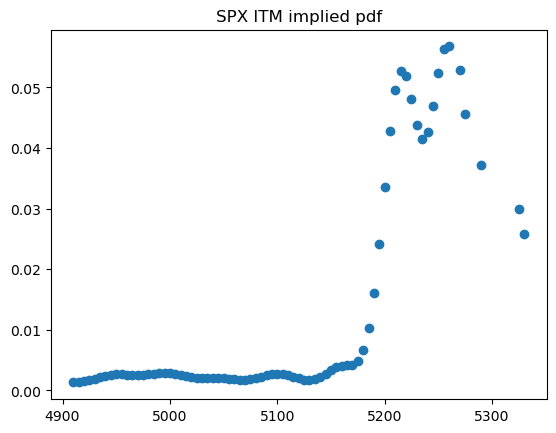

In [57]:
plt.scatter(spx_dist_dict.keys(), spx_dist_dict.values())
plt.title('SPX ITM implied pdf')

In [60]:
#P(SPX > 250 eod tommorrow?)
tups = [(sp, prob) for sp, prob in spx_dist_dict.items()]
tups.sort(key=lambda x:x[0])
cumsum = 0
for x in tups:
    if x[0] < 5160:
        cumsum+=x[1]
    else:
        print(cumsum)
        break

0.11474651923495893


Text(0.5, 1.0, 'NDX ITM implied pdf')

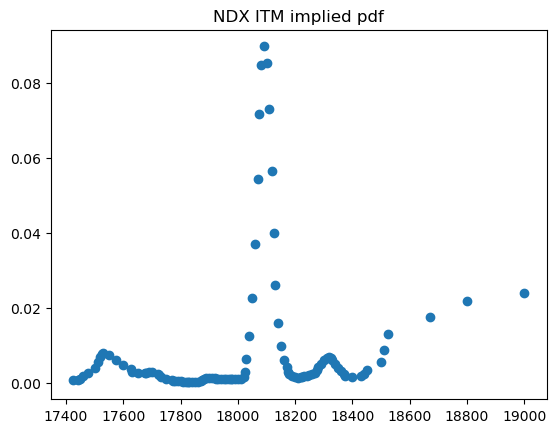

In [58]:
plt.scatter(ndx_dist_dict.keys(), ndx_dist_dict.values())
plt.title('NDX ITM implied pdf')

In [61]:
threshold = .025

spx_otm_temp = spx_otm[(spx_otm['strike']>cur_spx_val*(1-threshold)) & (spx_otm['strike']<cur_spx_val*(1+threshold))].reset_index(drop=True)
spx_dist_dict = {}
for idx, row in spx_otm_temp.iterrows():
    if idx == 0 or idx == spx_otm_temp.shape[0]-1:
        continue
    prev_strike = float(spx_otm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(spx_otm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(spx_otm_temp.iloc[idx-1]['midprice']) + float(spx_otm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    spx_dist_dict[cur_strike] = max(0,p)

spx_probs_smoothed = gaussian_filter1d(list(spx_dist_dict.values()), 3)
i = 0
for k, v in spx_dist_dict.items():
    spx_dist_dict[k] = spx_probs_smoothed[i]/sum(spx_probs_smoothed)
    i+=1


ndx_otm_temp = ndx_otm[(ndx_otm['strike']>cur_ndx_val*(1-threshold)) & (ndx_otm['strike']<cur_ndx_val*(1+threshold))].reset_index(drop=True)
ndx_dist_dict = {}
for idx, row in ndx_otm_temp.iterrows():
    if idx == 0 or idx == ndx_otm_temp.shape[0]-1:
        continue
    prev_strike = float(ndx_otm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(ndx_otm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(ndx_otm_temp.iloc[idx-1]['midprice']) + float(ndx_otm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    ndx_dist_dict[cur_strike] = max(0,p)
    
ndx_probs_smoothed = gaussian_filter1d(list(ndx_dist_dict.values()), 3)
i = 0
for k, v in ndx_dist_dict.items():
    ndx_dist_dict[k] = ndx_probs_smoothed[i]/sum(ndx_probs_smoothed)
    i+=1

        

Text(0.5, 1.0, 'SPX OTM implied pdf')

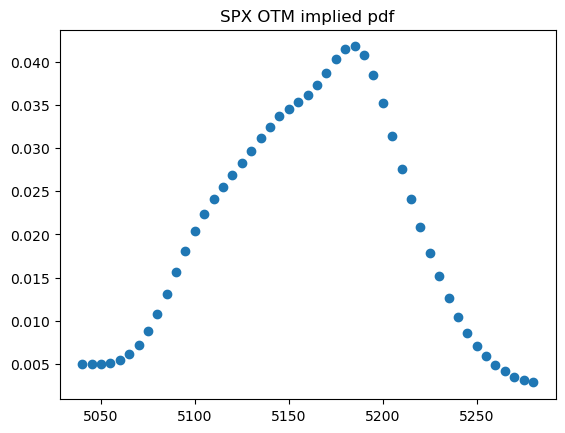

In [62]:
plt.scatter(spx_dist_dict.keys(), spx_dist_dict.values())
plt.title('SPX OTM implied pdf')

In [69]:
#P(SPX > 5250 eod tommorrow?)
tups = [(sp, prob) for sp, prob in spx_dist_dict.items()]
tups.sort(key=lambda x:x[0])
cumsum = 0
for x in tups:
    if x[0] < 5125:
        cumsum+=x[1]
    else:
        print(cumsum)
        break

0.22462479258196472


Text(0.5, 1.0, 'NDX OTM implied pdf')

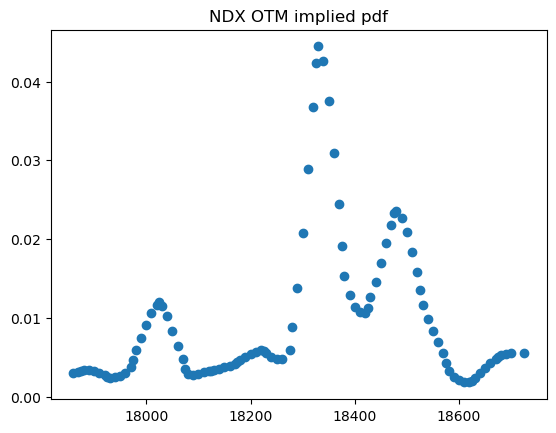

In [63]:
plt.scatter(ndx_dist_dict.keys(), ndx_dist_dict.values())
plt.title('NDX OTM implied pdf')